# Two Layer Model
This notebook implements a two-layer regression model:
- Layer 1: Random Forest regression to predict ESG Pillar scores and Disclosure scores
- Layer 2: Linear Regression to predict ESG Score

In [1]:
import sys
import os

# Add the parent directory to the system path
sys.path.append(os.path.abspath('..'))

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import numpy as np
from transformer.data_preprocessing import prepare_data_for_modeling
from TwoLayerModel import TwoLayerModel, plot_actual_vs_predicted_two_layer

### 1. Data preparation 

In [2]:
# Define the pillar and disclosure columns that will be used as intermediate targets
pillar_disclosure_columns = [
    'BESG Environmental Pillar Score',
    'BESG Social Pillar Score',
    'BESG Governance Pillar Score',
    'ESG Disclosure Score',
    'Environmental Disclosure Score',
    'Social Disclosure Score',
    'Governance Disclosure Score'
]

# Final target column
final_target = 'BESG ESG Score'

In [3]:
# Define the relative path to the CSV file
file_path = os.path.join('..', 'Data', 'energy_cleaned.csv')

# Load the data
df = pd.read_csv(file_path)

# Display the first few rows
df.head()

,Company,Ticker,Year,BESG ESG Score,BESG Environmental Pillar Score,BESG Social Pillar Score,BESG Governance Pillar Score,ESG Disclosure Score,Environmental Disclosure Score,Social Disclosure Score,...,Raw Materials Used,Percentage Gender Pay Gap Employees Ex Management,Percentage Raw Material from Sustainable Sources,"Revenue, Adj","Net Income, Adj",Margin %,"EPS, Adj",Market Cap ($M),Market Cap Category,Country
0,ACS Actividades de Construccion y Servicios SA,ACS,2014,NaN,NaN,NaN,NaN,50.729,37.511,33.676,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13716.9,Mid Cap,Spain
1,ACS Actividades de Construccion y Servicios SA,ACS,2015,1.850,0.660,2.380,3.660,55.296,42.616,41.717,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13716.9,Mid Cap,Spain
2,ACS Actividades de Construccion y Servicios SA,ACS,2016,2.170,1.130,2.370,4.050,55.497,48.354,36.578,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13716.9,Mid Cap,Spain
3,ACS Actividades de Construccion y Servicios SA,ACS,2017,2.760,1.130,4.300,4.110,57.248,50.317,44.891,...,"5,140.650",NaN,NaN,NaN,NaN,NaN,NaN,13716.9,Mid Cap,Spain
4,ACS Actividades de Construccion y Servicios SA,ACS,2018,2.630,1.110,4.200,3.640,62.609,52.280,59.039,...,"8,653.300",NaN,NaN,NaN,NaN,NaN,NaN,13716.9,Mid Cap,Spain


In [4]:
# Remove rows with missing BESG ESG Score
df = df.dropna(subset=['BESG ESG Score'])
df['BESG ESG Score'].isna().sum()

# Drop columns with more than 70% missing values
df = df.dropna(thresh=0.7*len(df), axis=1)

# Drop Market Cap column
df = df.drop(columns=['Market Cap ($M)'])

# Drop rows with '#N/A Requesting Data...'
df = df[~df['BESG ESG Score'].str.contains('#N/A Requesting Data...')]

df.shape

(850, 67)

In [5]:
numeric_cols = [
    'BESG ESG Score', 'BESG Environmental Pillar Score', 'BESG Social Pillar Score',
    'BESG Governance Pillar Score', 'ESG Disclosure Score', 'Environmental Disclosure Score',
    'Social Disclosure Score', 'Governance Disclosure Score', 'Nitrogen Oxide Emissions',
    'VOC Emissions', 'Particulate Emissions', 'Sulphur Dioxide / Sulphur Oxide Emissions',
    'GHG Scope 1', 'GHG Scope 2 Location-Based', 'GHG Scope 3', 'Carbon per Unit of Production',
    'Fuel Used - Natural Gas', 'Energy Per Unit of Production', 'Community Spending',
    'Pct Women in Middle and or Other Management', 'Pct Women in Workforce',
    'Fatalities - Employees', 'Fatalities - Contractors', 'Fatalities - Total',
    'Lost Time Incident Rate - Employees', 'Lost Time Incident Rate - Contractors',
    'Lost Time Incident Rate - Workforce', 'Total Recordable Incident Rate - Employees',
    'Total Recordable Incident Rate - Contractors', 'Total Recordable Incident Rate - Workforce',
    'Number of Employees - CSR', 'Number of Contractors', 'Employee Turnover Pct',
    'Years Auditor Employed', 'Size of Audit Committee',
    'Number of Independent Directors on Audit Committee', 'Audit Committee Meetings',
    'Audit Committee Meeting Attendance Percentage', 'Board Size',
    'Number of Executives / Company Managers', 'Number of Non Executive Directors on Board',
    'Number of Board Meetings for the Year', 'Board Meeting Attendance Pct',
    'Size of Compensation Committee', 'Num of Independent Directors on Compensation Cmte',
    'Number of Compensation Committee Meetings', 'Compensation Committee Meeting Attendance %',
    'Number of Female Executives', 'Number of Women on Board',
    'Age of the Youngest Director', 'Age of the Oldest Director',
    'Number of Independent Directors', 'Size of Nomination Committee',
    'Num of Independent Directors on Nomination Cmte', 'Number of Nomination Committee Meetings',
    'Nomination Committee Meeting Attendance Percentage', 'Board Duration (Years)',
    'Carbon Monoxide Emissions', 'CO2 Scope 1', 'Total Energy Consumption',
    'Electricity Used', 'Total Waste', 'Waste Recycled', 'Waste Sent to Landfills',
    'Total Water Withdrawal', 'Total Water Discharged', 'Water Consumption',
    'Pct Women in Senior Management', 'Pct Minorities in Workforce',
    'Pct Employees Unionized', 'Employee Training Cost',
    'Total Hours Spent by Firm - Employee Training', 'Fuel Used - Coal/Lignite',
    'Fuel Used - Crude Oil/Diesel', 'Hazardous Waste',
    'Pct Minorities in Management', 'Pct Disabled in Workforce',
    'CO2 Scope 2 Location-Based', 'Water per Unit of Production', 'Pct Recycled Materials',
    'Number of Suppliers Audited', 'Percentage Suppliers Audited',
    'Number of Supplier Audits Conducted', 'Number Supplier Facilities Audited',
    'Percentage of Suppliers in Non-Compliance', 'Number of Customer Complaints',
    'Raw Materials Used', 'Revenue, Adj', 'Net Income, Adj'
]

for col in df.columns:
    if col in numeric_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce')

binary_cols = [
    'Risks of Climate Change Discussed', 'Policy Against Child Labor',
    'Gender Pay Gap Breakout', 'Human Rights Policy', 'Equal Opportunity Policy',
    'Business Ethics Policy', 'Anti-Bribery Ethics Policy', 'Health and Safety Policy',
    'Training Policy', 'Social Supply Chain Management', 'Emissions Reduction Initiatives',
    'Climate Change Policy', 'Climate Change Opportunities Discussed',
    'Energy Efficiency Policy', 'Waste Reduction Policy',
    'Environmental Supply Chain Management', 'Water Policy', 'Biodiversity Policy',
    'Quality Assurance and Recall Policy', 'Consumer Data Protection Policy',
    'Fair Remuneration Policy', 'Employee CSR Training', 'Renewable Energy Use',
    'Company Conducts Board Evaluations', 'Company Has Executive Share Ownership Guidelines',
    'Director Share Ownership Guidelines', 'Transition Plan Claim',
    'Adopts TNFD Recommendations', 'Zero Deforestation Policy',
    'Board Level Oversight of Biodiversity', 'Executive Level Oversight of Biodiversity',
    'Company Discloses Employee Engagement Score', 'Verification Type'
]

# Impute missing values for numeric columns
for col in numeric_cols:
    if col in df.columns:
        df[col] = df[col].fillna(df[col].mean())

# Impute missing values for binary columns
for col in binary_cols:
    if col in df.columns:
        df[col] = df[col].map({'Yes': 1, 'No': 0, 'yes': 1, 'no': 0}).astype('bool')
        df[col] = df[col].fillna(df[col].mode()[0])

# Impute missing values for categorical columns
for col in df.columns:
    if df[col].dtype == 'object' and col not in ['Company', 'Ticker']:
        df[col] = df[col].fillna(df[col].mode()[0])
        df[col] = df[col].astype('category')

# Check if there are any missing values
df.isnull().sum()

Company                            0
Ticker                             0
Year                               0
BESG ESG Score                     0
BESG Environmental Pillar Score    0
                                  ..
Fair Remuneration Policy           0
Verification Type                  0
Employee CSR Training              0
Market Cap Category                0
Country                            0
Length: 67, dtype: int64

In [6]:
# One-hot encode categorical columns without Company and Ticker
df = pd.get_dummies(df, columns=df.select_dtypes(include='category').columns)

df.head()

,Company,Ticker,Year,BESG ESG Score,BESG Environmental Pillar Score,BESG Social Pillar Score,BESG Governance Pillar Score,ESG Disclosure Score,Environmental Disclosure Score,Social Disclosure Score,...,Country_New Zealand,Country_Norway,Country_Poland,Country_Portugal,Country_Spain,Country_Switzerland,Country_Thailand,Country_United Arab Emirates,Country_United Kingdom,Country_United States
1,ACS Actividades de Construccion y Servicios SA,ACS,2015,1.85,0.66,2.38,3.66,55.296,42.616,41.717,...,False,False,False,False,True,False,False,False,False,False
2,ACS Actividades de Construccion y Servicios SA,ACS,2016,2.17,1.13,2.37,4.05,55.497,48.354,36.578,...,False,False,False,False,True,False,False,False,False,False
3,ACS Actividades de Construccion y Servicios SA,ACS,2017,2.76,1.13,4.30,4.11,57.248,50.317,44.891,...,False,False,False,False,True,False,False,False,False,False
4,ACS Actividades de Construccion y Servicios SA,ACS,2018,2.63,1.11,4.20,3.64,62.609,52.280,59.039,...,False,False,False,False,True,False,False,False,False,False
5,ACS Actividades de Construccion y Servicios SA,ACS,2019,2.79,1.31,4.21,3.87,64.390,57.626,59.039,...,False,False,False,False,True,False,False,False,False,False


In [7]:
# Columns to drop from features
cols_to_drop = [
    'BESG ESG Score',
    'BESG Environmental Pillar Score',
    'BESG Social Pillar Score',
    'BESG Governance Pillar Score',
    'ESG Disclosure Score',
    'Environmental Disclosure Score',
    'Social Disclosure Score',
    'Governance Disclosure Score',
    'Company',
    'Ticker'
]

In [8]:
# Drop rows with missing ESG scores
df, cat_features, num_features = prepare_data_for_modeling(df)

print(f"Number of categorical features: {len(cat_features)}")
print(f"Number of numerical features: {len(num_features)}")

# Show sample of features
print("\nSample categorical features:", cat_features[:5])
print("Sample numerical features:", num_features[:5])

# Split the data into training, validation, and test sets
X = df[cat_features + num_features]

# Verify columns to drop are in the DataFrame
print(f"Columns before dropping: {X.columns.tolist()}")

# Drop the specified columns
cols_to_drop = ['BESG Environmental Pillar Score', 'BESG Social Pillar Score', 'BESG Governance Pillar Score', 'ESG Disclosure Score', 'Environmental Disclosure Score', 'Social Disclosure Score', 'Governance Disclosure Score', 'Company', 'Ticker']
X = X.drop(columns=cols_to_drop)

# Verify columns after dropping
print(f"Columns after dropping: {X.columns.tolist()}")

# Update cat_features and num_features to exclude dropped columns
cat_features = [col for col in cat_features if col not in cols_to_drop]
num_features = [col for col in num_features if col not in cols_to_drop]

y = df[['BESG ESG Score', 'BESG Environmental Pillar Score', 'BESG Social Pillar Score', 'BESG Governance Pillar Score', 'ESG Disclosure Score', 'Environmental Disclosure Score', 'Social Disclosure Score', 'Governance Disclosure Score']]

# First split: train+val vs test (80% vs 20%)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Second split: train vs val (80% vs 20% of train_val, which is 64% vs 16% of the original data)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

Identified 3 categorical features
Identified 41 numerical features
Number of categorical features: 3
Number of numerical features: 41

Sample categorical features: ['Company', 'Ticker', 'Year']
Sample numerical features: ['BESG Environmental Pillar Score', 'BESG Social Pillar Score', 'BESG Governance Pillar Score', 'ESG Disclosure Score', 'Environmental Disclosure Score']
Columns before dropping: ['Company', 'Ticker', 'Year', 'BESG Environmental Pillar Score', 'BESG Social Pillar Score', 'BESG Governance Pillar Score', 'ESG Disclosure Score', 'Environmental Disclosure Score', 'Social Disclosure Score', 'Governance Disclosure Score', 'Nitrogen Oxide Emissions', 'GHG Scope 1', 'GHG Scope 2 Location-Based', 'Pct Women in Workforce', 'Fatalities - Employees', 'Fatalities - Total', 'Total Recordable Incident Rate - Employees', 'Number of Employees - CSR', 'Years Auditor Employed', 'Size of Audit Committee', 'Number of Independent Directors on Audit Committee', 'Audit Committee Meetings', 'A

### 2.  Train two-layer model for comparison


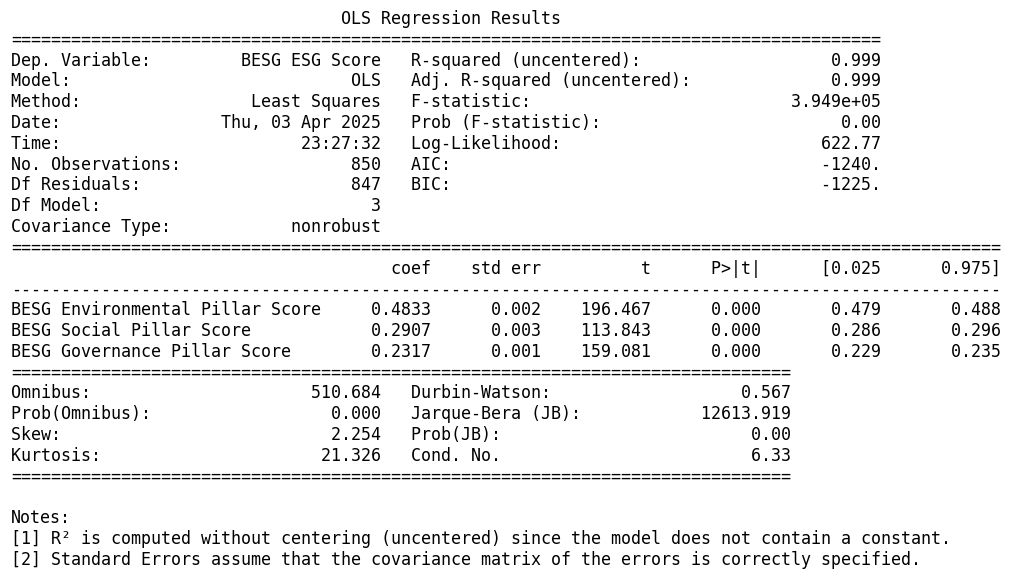

In [9]:
pillar_disclosure_columns = [
    'BESG Environmental Pillar Score',
    'BESG Social Pillar Score',
    'BESG Governance Pillar Score',
]

layer2_model = sm.OLS(y['BESG ESG Score'], y[pillar_disclosure_columns]).fit()

fig, ax = plt.subplots()
summary_text = str(layer2_model.summary())
ax.text(0.01, 0.05, summary_text, fontfamily='monospace', fontsize=12)
ax.axis('off')
plt.tight_layout()
plt.show()

In [10]:
two_layer_model = TwoLayerModel(cat_features, num_features, layer2_model.params)
two_layer_model.fit(X_train, y_train)
two_layer_metrics = two_layer_model.evaluate(X_test, y_test)

print("\n Two Layer Model Performance:")
print(two_layer_metrics)


 Two Layer Model Performance:
                            Target    Tier       MSE      RMSE       MAE  \
0  BESG Environmental Pillar Score  Tier 1  1.555473  1.247186  0.925222   
1         BESG Social Pillar Score  Tier 1  1.166696  1.080137  0.812900   
2     BESG Governance Pillar Score  Tier 1  0.565719  0.752143  0.516688   
3                   BESG ESG Score  Tier 2  0.694633  0.833447  0.634828   

   R² Score  Adjusted R² Score  
0  0.640091           0.633586  
1  0.640683           0.634189  
2  0.685173           0.679483  
3  0.694471           0.688950  


In [ ]:
# Save the model
import joblib
model_path = os.path.join('..', 'TwoLayerModel', 'two_layer_model.pkl')
joblib.dump(two_layer_model, model_path)
print(f"Model saved to {model_path}")

# Load the model (for usage in production)
loaded_model = joblib.load(model_path)
# Evaluate the loaded model
loaded_model_metrics = loaded_model.evaluate(X_test, y_test)
print("\n Loaded Model Performance:")
print(loaded_model_metrics)

Model saved to ../TwoLayerModel/two_layer_model.pkl

 Loaded Model Performance:
                            Target    Tier       MSE      RMSE       MAE  \
0  BESG Environmental Pillar Score  Tier 1  1.555473  1.247186  0.925222   
1         BESG Social Pillar Score  Tier 1  1.166696  1.080137  0.812900   
2     BESG Governance Pillar Score  Tier 1  0.565719  0.752143  0.516688   
3                   BESG ESG Score  Tier 2  0.694633  0.833447  0.634828   

   R² Score  Adjusted R² Score  
0  0.640091           0.633586  
1  0.640683           0.634189  
2  0.685173           0.679483  
3  0.694471           0.688950  


/var/folders/08/xxsq81ks0gx_hgrmn3w7_0p00000gn/T/ipykernel_96455/4210039086.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=two_layer_metrics['Target'], y=two_layer_metrics[metric], palette='viridis')


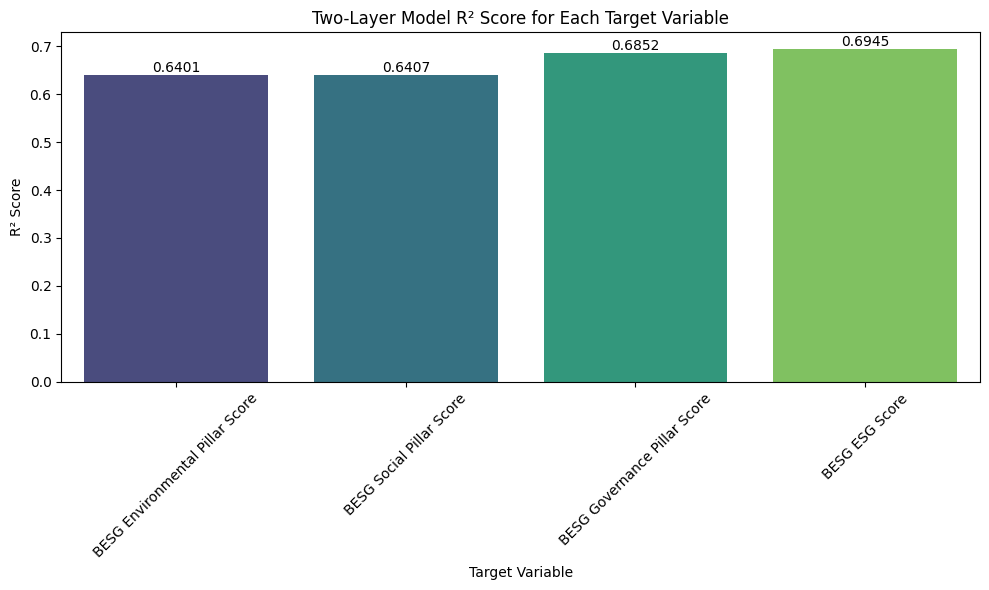

/var/folders/08/xxsq81ks0gx_hgrmn3w7_0p00000gn/T/ipykernel_96455/4210039086.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=two_layer_metrics['Target'], y=two_layer_metrics[metric], palette='viridis')


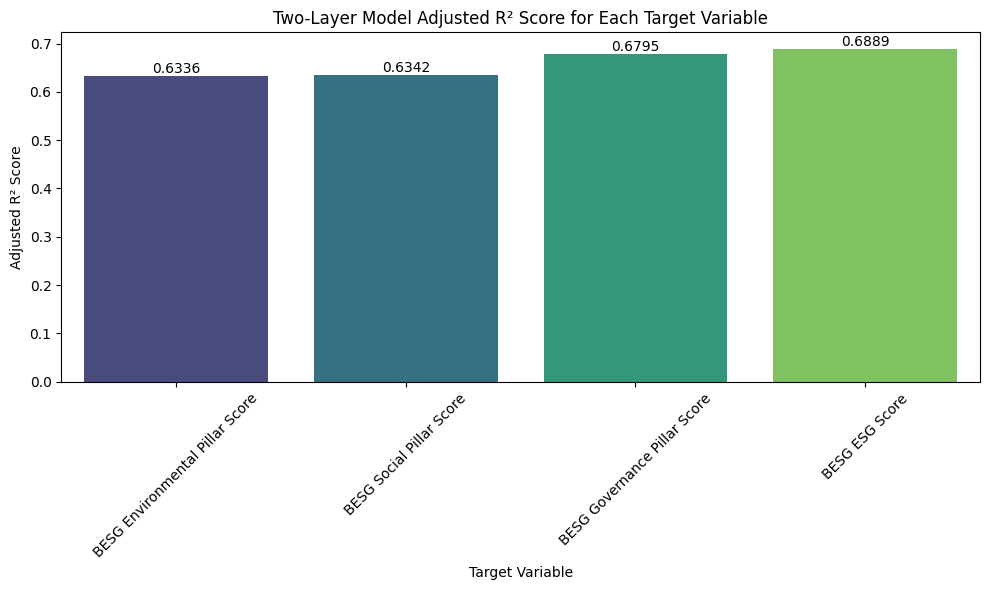

/var/folders/08/xxsq81ks0gx_hgrmn3w7_0p00000gn/T/ipykernel_96455/4210039086.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=two_layer_metrics['Target'], y=two_layer_metrics[metric], palette='viridis')


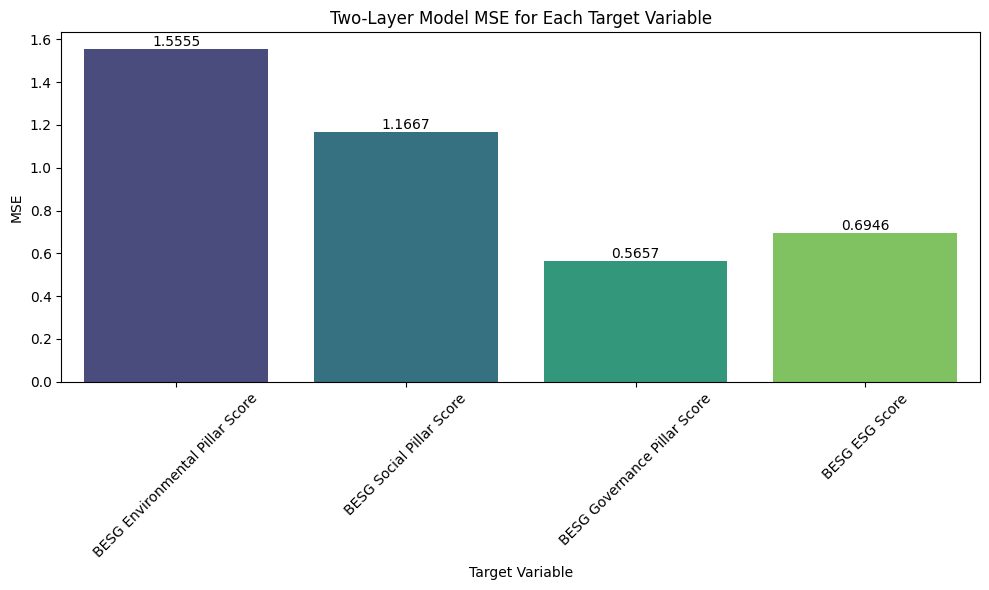

/var/folders/08/xxsq81ks0gx_hgrmn3w7_0p00000gn/T/ipykernel_96455/4210039086.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=two_layer_metrics['Target'], y=two_layer_metrics[metric], palette='viridis')


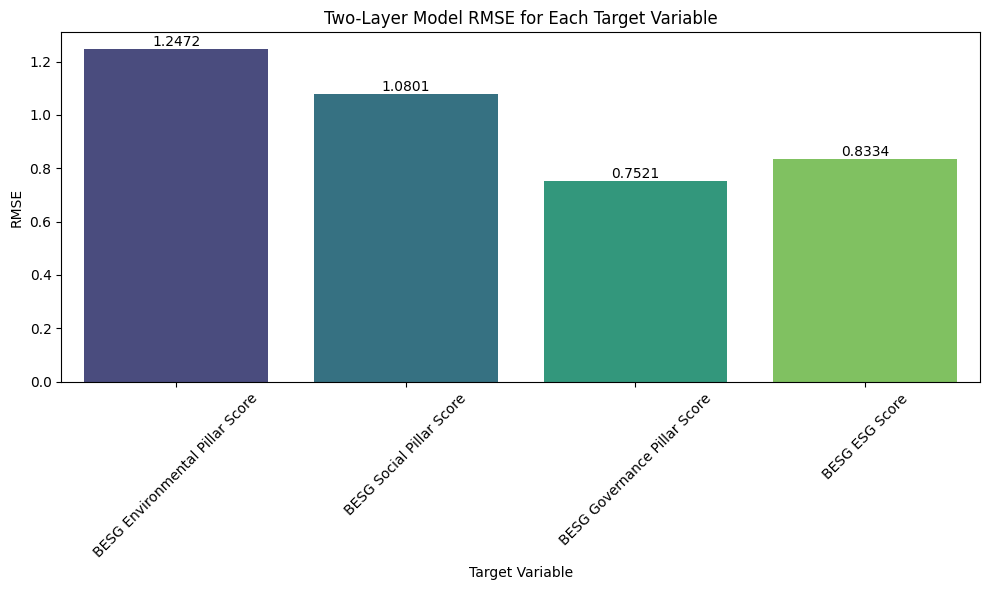

/var/folders/08/xxsq81ks0gx_hgrmn3w7_0p00000gn/T/ipykernel_96455/4210039086.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=two_layer_metrics['Target'], y=two_layer_metrics[metric], palette='viridis')


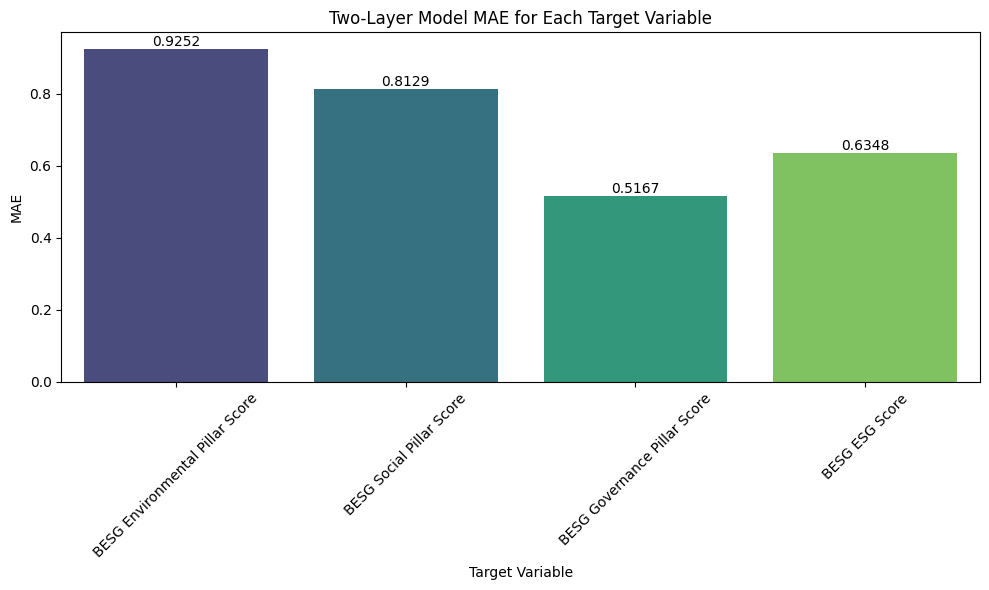

In [11]:
# Plot performance metrics for each target variable
for metric in ['R² Score', 'Adjusted R² Score', 'MSE', 'RMSE', 'MAE']:
    plt.figure(figsize=(10, 6))
    sns.barplot(x=two_layer_metrics['Target'], y=two_layer_metrics[metric], palette='viridis')
    plt.title(f'Two-Layer Model {metric} for Each Target Variable')
    plt.xlabel('Target Variable')
    plt.ylabel(metric)
    plt.xticks(rotation=45)
    # Annotate each bar with its value
    for index, value in enumerate(two_layer_metrics[metric]):
        plt.text(index, value, f'{value:.4f}', ha='center', va='bottom')
    plt.tight_layout()
    plt.show()

/var/folders/08/xxsq81ks0gx_hgrmn3w7_0p00000gn/T/ipykernel_96455/1272445111.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importances.head(20), palette='viridis')


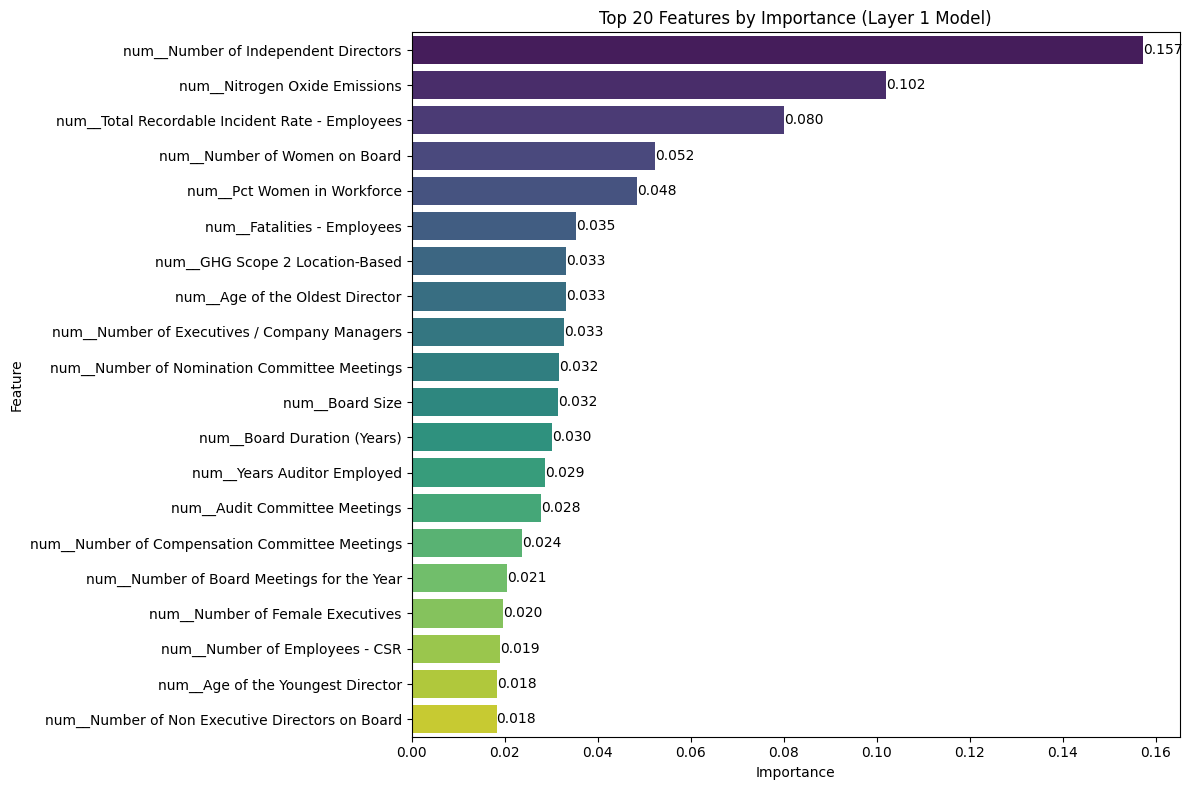

In [12]:
# Feature importance analysis for Layer 1
# Extract the trained RandomForestRegressor from the Layer 1 model
rf_regressor = two_layer_model.layer1_model.named_steps['regressor']

# Get feature importances
importances = rf_regressor.feature_importances_

# Get feature names from the preprocessor
feature_names = two_layer_model.layer1_model.named_steps['preprocessor'].get_feature_names_out()

# Create a DataFrame for plotting
feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Plot top 20 features by importance
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importances.head(20), palette='viridis')
plt.title('Top 20 Features by Importance (Layer 1 Model)')
plt.xlabel('Importance')
plt.ylabel('Feature')

# Label each bar
for i in range(min(20, len(feature_importances))):
    plt.text(x=feature_importances['Importance'].iloc[i], y=i,
             s=f"{feature_importances['Importance'].iloc[i]:.3f}",
             va='center')
plt.tight_layout()
plt.show()

/var/folders/08/xxsq81ks0gx_hgrmn3w7_0p00000gn/T/ipykernel_96455/1332992097.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importances.head(15), palette='viridis')


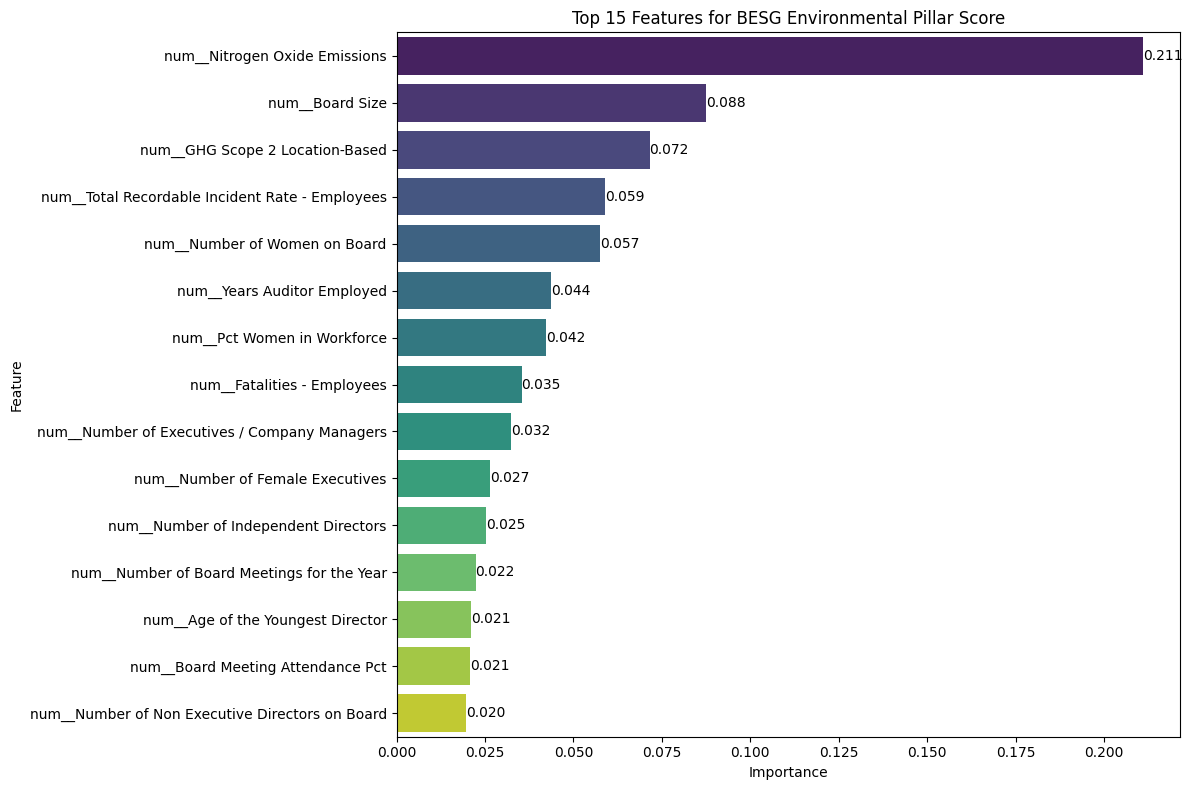

/var/folders/08/xxsq81ks0gx_hgrmn3w7_0p00000gn/T/ipykernel_96455/1332992097.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importances.head(15), palette='viridis')


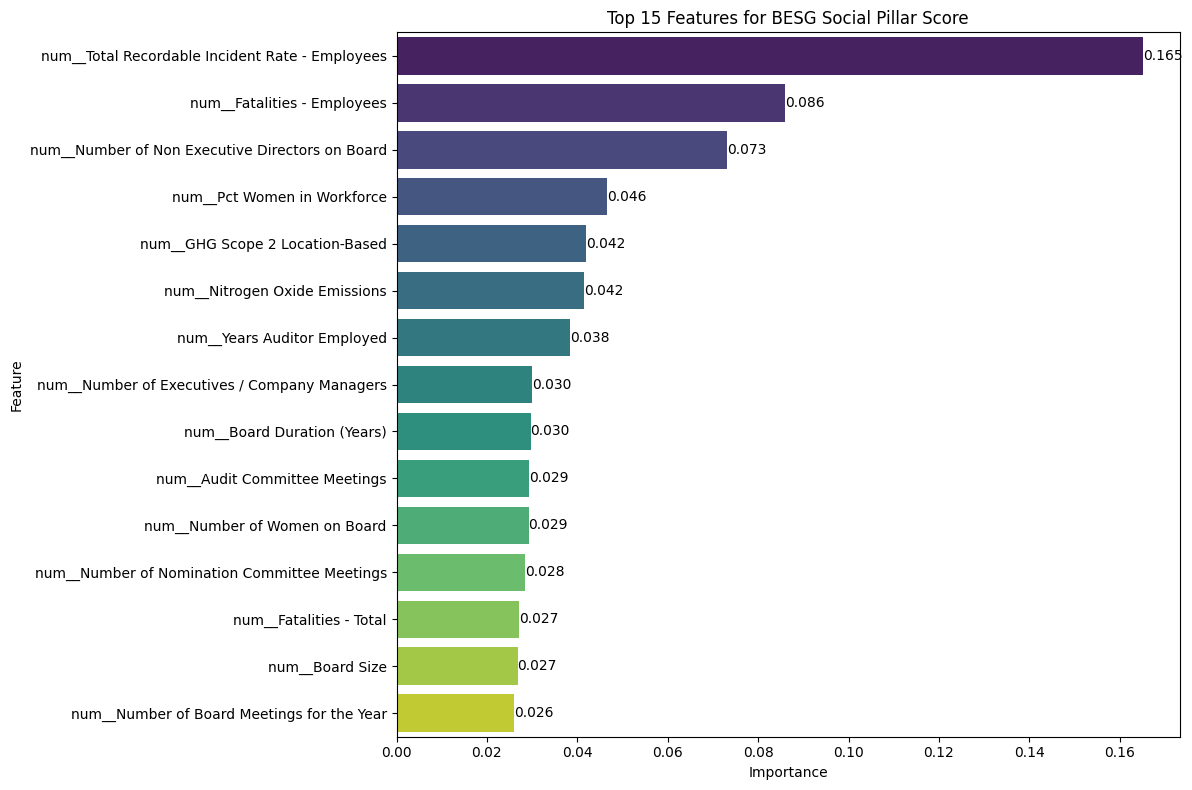

/var/folders/08/xxsq81ks0gx_hgrmn3w7_0p00000gn/T/ipykernel_96455/1332992097.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importances.head(15), palette='viridis')


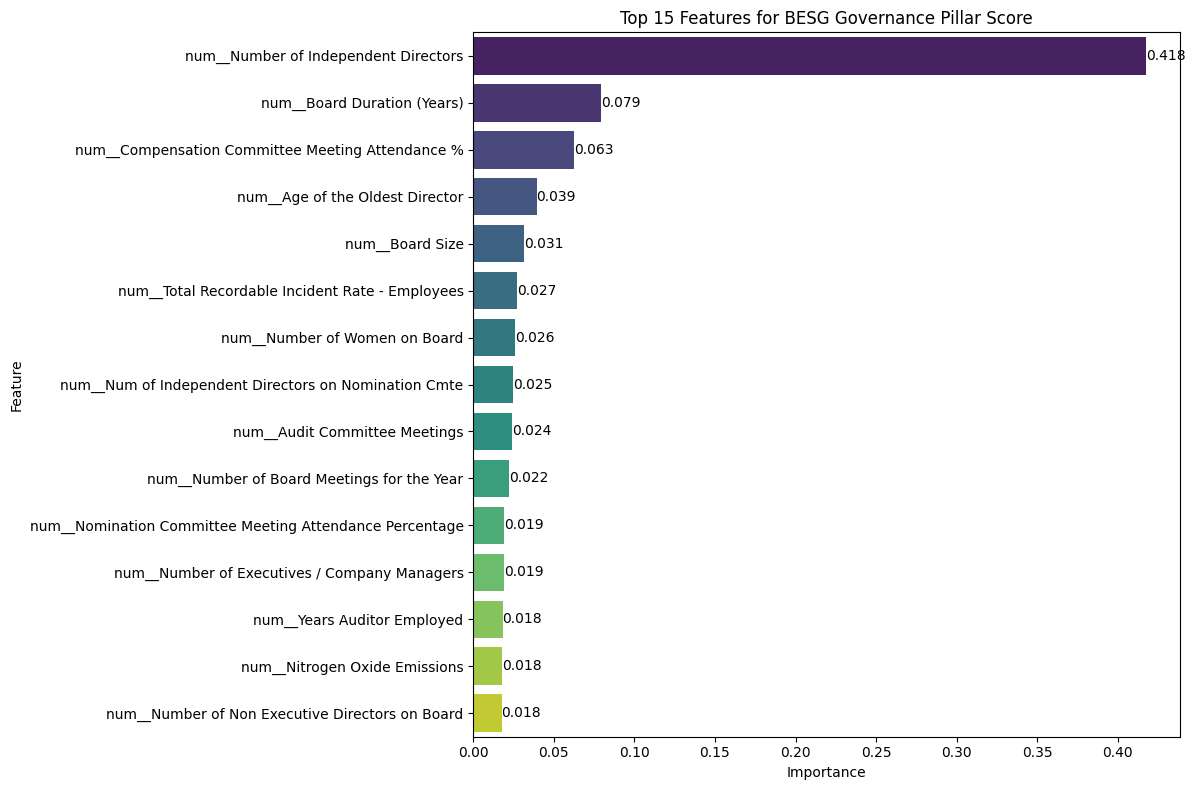

In [13]:
# Loop through each target and train a specific model
for i, target in enumerate(pillar_disclosure_columns):
    # Create preprocessing pipeline
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, num_features),
            ('cat', categorical_transformer, cat_features)
        ])

    # Create a model specifically for this target
    target_model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', RandomForestRegressor(n_estimators=100, max_depth=15, random_state=42))
    ])

    # Train the model on this specific target
    target_model.fit(X_train, y_train[target])

    # Get feature importances for this target
    rf_regressor = target_model.named_steps['regressor']
    importances = rf_regressor.feature_importances_
    feature_names = target_model.named_steps['preprocessor'].get_feature_names_out()

    # Create DataFrame for plotting
    feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
    feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

    # Store feature importances to a CSV file
    feature_importances.to_csv(f'feature_importances_{target}.csv', index=False)

    # Create plot
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_importances.head(15), palette='viridis')
    plt.title(f'Top 15 Features for {target}', fontsize=12)
    plt.xlabel('Importance')
    plt.ylabel('Feature')

    # Label each bar
    for j in range(min(15, len(feature_importances))):
        plt.text(x=feature_importances['Importance'].iloc[j], y=j,
                 s=f"{feature_importances['Importance'].iloc[j]:.3f}",
                 va='center')

    plt.tight_layout()
    plt.subplots_adjust(hspace=0.5)
    plt.show()

In [14]:
# Analyze the coefficients of the Layer 2 Linear Regression model
layer2_coefficients = pd.DataFrame({
    'Pillar/Disclosure Score': pillar_disclosure_columns,
    # extract coefficients from OLS model
    'Coefficient': two_layer_model.layer2_model
})

print("\nLayer 2 Model Coefficients:")
print(layer2_coefficients)


Layer 2 Model Coefficients:
                                         Pillar/Disclosure Score  Coefficient
BESG Environmental Pillar Score  BESG Environmental Pillar Score     0.483350
BESG Social Pillar Score                BESG Social Pillar Score     0.290668
BESG Governance Pillar Score        BESG Governance Pillar Score     0.231662


In [15]:
# Compare Layer 2 coefficients to a simple linear regression model

X = df[pillar_disclosure_columns]
y = df[final_target]

lr_model = sm.OLS(y, X).fit()
print("\nLinear Regression Model Summary:")
lr_summary = lr_model.summary()

print("\nComparison of Layer 2 Model Coefficients and Linear Regression Coefficients:")

comparison_df = pd.DataFrame({
    'Layer 2': two_layer_model.layer2_model,
    'Linear Regression': lr_model.params
}, index=pillar_disclosure_columns)

comparison_df = comparison_df.sort_values(by='Layer 2', ascending=False)
print(comparison_df)


Linear Regression Model Summary:

Comparison of Layer 2 Model Coefficients and Linear Regression Coefficients:
                                  Layer 2  Linear Regression
BESG Environmental Pillar Score  0.483350           0.483350
BESG Social Pillar Score         0.290668           0.290668
BESG Governance Pillar Score     0.231662           0.231662


/var/folders/08/xxsq81ks0gx_hgrmn3w7_0p00000gn/T/ipykernel_96455/4241095067.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Coefficient', y='Pillar/Disclosure Score', data=layer2_coefficients, palette='coolwarm')


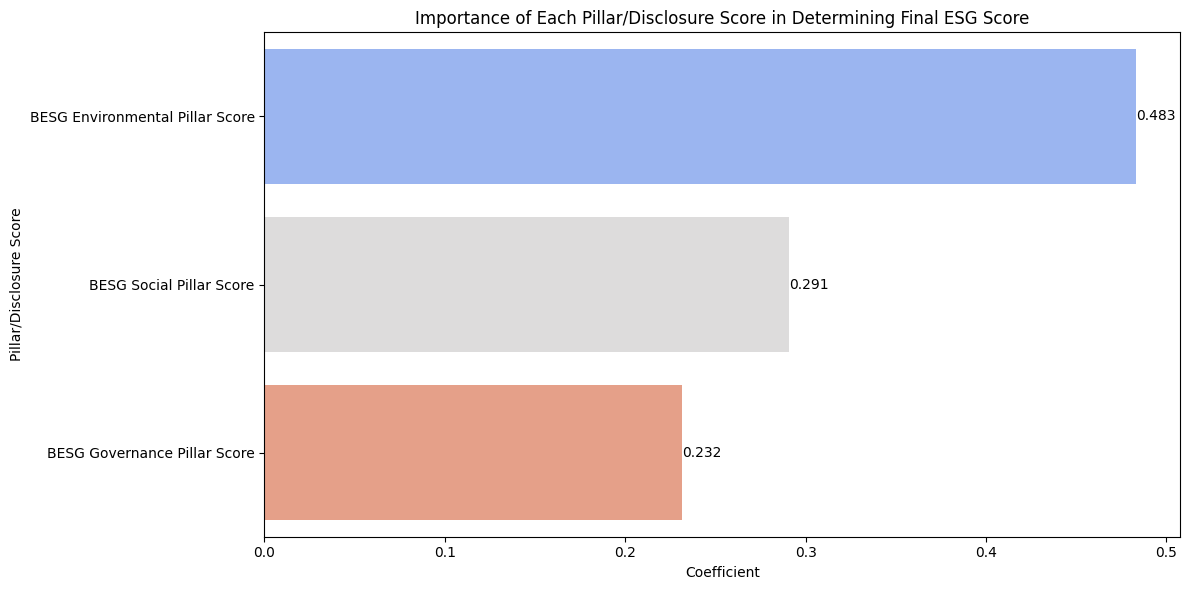

In [16]:
# Plot coefficients
plt.figure(figsize=(12, 6))
sns.barplot(x='Coefficient', y='Pillar/Disclosure Score', data=layer2_coefficients, palette='coolwarm')
plt.title('Importance of Each Pillar/Disclosure Score in Determining Final ESG Score')
plt.xlabel('Coefficient')
plt.ylabel('Pillar/Disclosure Score')
# Label each bar
for i in range(len(layer2_coefficients)):
    plt.text(x=layer2_coefficients['Coefficient'].iloc[i], y=i,
             s=f"{layer2_coefficients['Coefficient'].iloc[i]:.3f}",
             va='center')
plt.tight_layout()
plt.show()

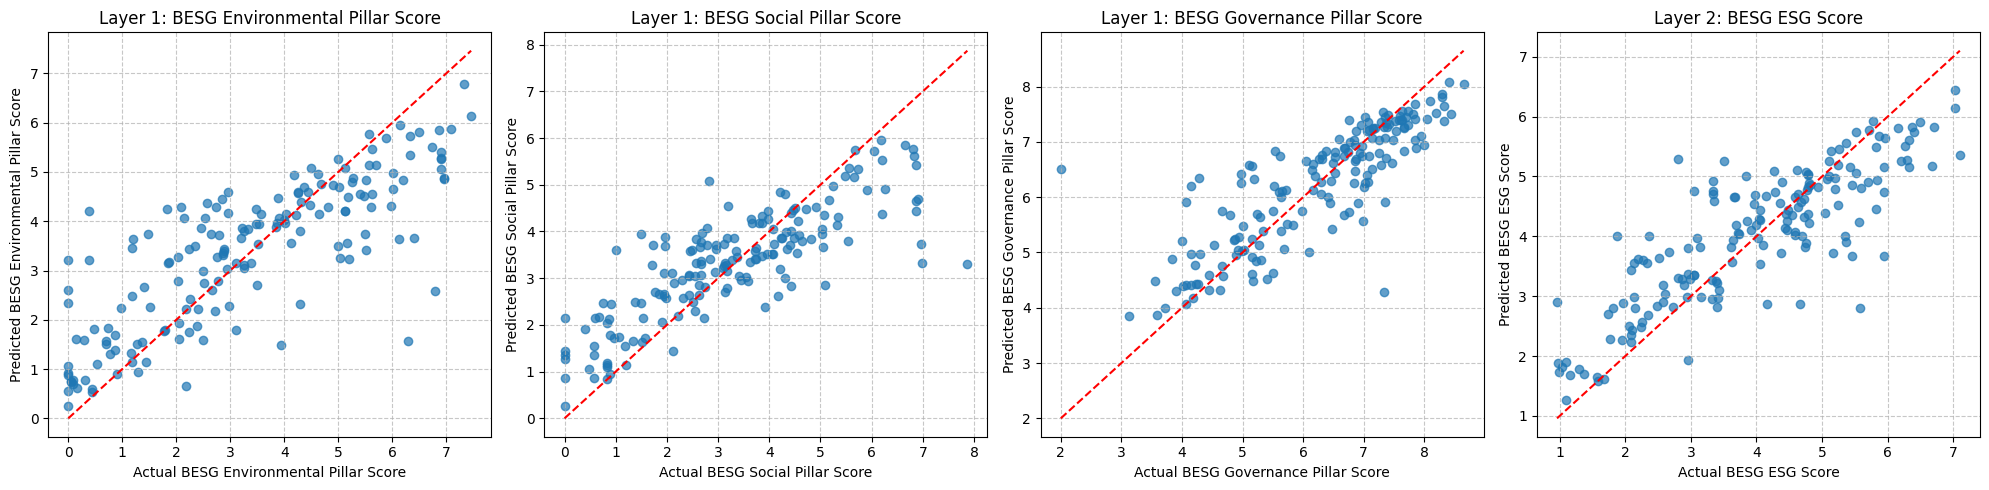

In [17]:
plot_actual_vs_predicted_two_layer(two_layer_model, X_test, y_test)

### 3. Train a single-layer model for additional comparison

In [18]:
# Define the preprocessing steps for baseline
numeric_transformer = Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors=5)),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_features),
        ('cat', categorical_transformer, cat_features)
    ])

# Create and train the baseline model
baseline_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, max_depth=15, random_state=42))
])

# Fit on training data (only predicting final ESG score)
baseline_model.fit(X_train, y_train[final_target])

# Make predictions
baseline_predictions = baseline_model.predict(X_test)

# Calculate metrics
baseline_mse = mean_squared_error(y_test[final_target], baseline_predictions)
baseline_rmse = np.sqrt(baseline_mse)
baseline_mae = mean_absolute_error(y_test[final_target], baseline_predictions)
baseline_r2 = r2_score(y_test[final_target], baseline_predictions)
baseline_adjusted_r2 = 1 - (1 - baseline_r2) * (len(y_test) - 1) / (len(y_test) - X_test.shape[1] - 1)

# Get two-tier model predictions
two_tier_predictions = two_layer_metrics[two_layer_metrics['Target'] == final_target]

# Create a comparison DataFrame
comparison = pd.DataFrame({
    'Model': ['Baseline (Single-Tier)', 'Two-Tier'],
    'MSE': [baseline_mse, two_tier_predictions['MSE'].values[0]],
    'RMSE': [baseline_rmse, two_tier_predictions['RMSE'].values[0]],
    'MAE': [baseline_mae, two_tier_predictions['MAE'].values[0]],
    'R-squared': [baseline_r2, two_tier_predictions['R² Score'].values[0]],
    'Adjusted R-squared': [baseline_adjusted_r2, two_tier_predictions['Adjusted R² Score'].values[0]]
})

print("\nComparison between Baseline and Two-Tier models for ESG Score prediction:")
print(comparison)


Comparison between Baseline and Two-Tier models for ESG Score prediction:
                    Model       MSE      RMSE       MAE  R-squared  \
0  Baseline (Single-Tier)  0.631904  0.794924  0.614773   0.722062   
1                Two-Tier  0.694633  0.833447  0.634828   0.694471   

   Adjusted R-squared  
0            0.649467  
1            0.688950  


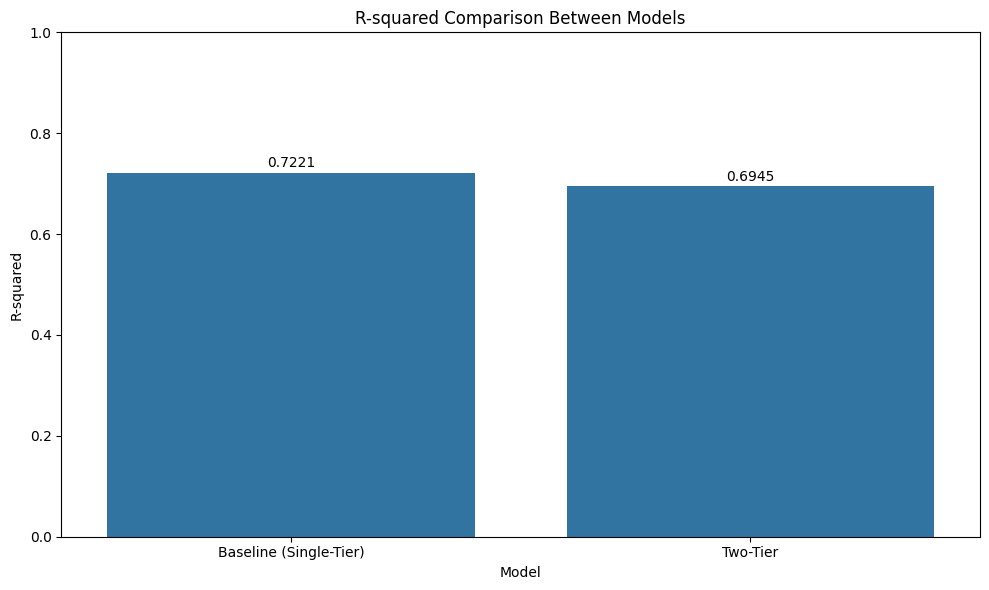

In [19]:
plt.figure(figsize=(10, 6))
barplot = sns.barplot(x='Model', y='R-squared', data=comparison)
plt.title('R-squared Comparison Between Models')
plt.ylim(0, 1)

# Add text labels
for i, bar in enumerate(barplot.patches):
    barplot.text(
        bar.get_x() + bar.get_width()/2,
        bar.get_height() + 0.01,
        f'{bar.get_height():.4f}',
        ha='center'
    )

plt.tight_layout()